# Import needed modules

In [1]:
model_count = 4
model1_name = 'ConvNeXtTiny'
model2_name = 'MobileNetV2'
model3_name = 'DenseNet121'
model4_name = 'InceptionV3'

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


# Create needed functions

#### **Function to create data frame**

In [3]:
# Generate data paths with labels
def define_paths(dir):
    filepaths = []
    labels = []

    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)

        for fold_ in filelist:
            foldpath_ = os.path.join(foldpath, fold_)
            filelist_ = os.listdir(foldpath_)

            for file_ in filelist_:
                fpath = os.path.join(foldpath_, file_)
                filepaths.append(fpath)
                labels.append(fold_)

    return filepaths, labels


# Concatenate data paths with labels into one dataframe ( to later be fitted into the model )
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)


# Function that create dataframe for train, and test data (stacking)
def create_df(data_dir):

    # train dataframe
    files1, classes1 = define_paths(data_dir[0])
    train_df = define_df(files1, classes1)    # d1

    # test dataframe
    files, classes = define_paths(data_dir[1])
    test_df = define_df(files, classes)       # d2

    # strat = train_df['labels']
    # train1_df, train2_df = train_test_split(train_df, train_size=0.8, shuffle=True, random_state=123, stratify=strat)  # 80% d1 train, 20% d1 test

    # strat = test_df['labels']
    # test1_df, test2_df = train_test_split(test_df, train_size=0.2, shuffle=True, random_state=123, stratify=strat) # 20% d2 train, 80% d2 test

    # train_new_df = pd.concat([train1_df,test1_df]) # train -> d1:d2 - 80:20

    # test_new_df = pd.concat([train2_df,test2_df]) # test -> d1:d2 - 20:80

    return train_df, test_df

#### **Function to display data sample**

In [4]:
def show_images(gen):
    '''
    This function take the data generator and show sample of the images
    '''

    # return classes , images to be displayed
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator

    # calculate number of displayed samples
    length = len(labels)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

#### **Function to plot value counts for a column in a dataframe**

In [5]:
def plot_label_count(df, plot_title):
    '''
    This function take df and plot labels value counts
    '''

    # Define needed variables
    vcounts = df['labels'].value_counts()
    labels = vcounts.keys().tolist()
    values = vcounts.tolist()
    lcount = len(labels)

    if lcount > 55:
        print('The number of labels is > 55, no plot will be produced')

    else:
        plot_labels(lcount, labels, values, plot_title)

def plot_labels(lcount, labels, values, plot_title):
    width = lcount * 4
    width = np.min([width, 20])

    plt.figure(figsize= (width, 5))

    form = {'family': 'serif', 'color': 'blue', 'size': 25}
    sns.barplot(labels, values)
    plt.title(f'Images per Label in {plot_title} data', fontsize= 24, color= 'blue')
    plt.xticks(rotation= 90, fontsize= 18)
    plt.yticks(fontsize= 18)
    plt.xlabel('CLASS', fontdict= form)
    yaxis_label = 'IMAGE COUNT'
    plt.ylabel(yaxis_label, fontdict= form)

    rotation = 'vertical' if lcount >= 8 else 'horizontal'
    for i in range(lcount):
        plt.text(i, values[i] / 2, str(values[i]), fontsize= 12,
                rotation= rotation, color= 'yellow', ha= 'center')

    plt.show()

#### **Function to create Confusion Matrix**

In [6]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	'''
	This function plot confusion matrix method from sklearn package.
	'''

	plt.figure(figsize= (10, 10))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()

	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)

	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')

	else:
		print('Confusion Matrix, Without Normalization')

	print(cm)

	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')

# **Model Structure**

#### **Start Reading Dataset**

In [7]:
data_dir = ['/content/drive/MyDrive/C-NMC_Leukemia/training_data','/content/drive/MyDrive/C-NMC_Leukemia/validation_data']

try:
    # Get splitted data
    train_df, test_df = create_df(data_dir)

except:
    print('Invalid Input')


#### Define batch size, and steps, and image data Generator

In [8]:
# Recommended : use custom function for test data batch size, else we can use normal batch size.
batch_size = 40
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# define model parameters
img_size = (224, 224)
channels = 3 # either BGR or Grayscale
color = 'rgb'
img_shape = (img_size[0], img_size[1], channels)

def scalar(img):
    return img

# train gen with data augnmentation, valid and test gen does not have augmentation
tr_gen = ImageDataGenerator(preprocessing_function= scalar)
ts_gen = ImageDataGenerator(preprocessing_function= scalar)

# Get Generators
train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= batch_size)


Found 8035 validated image filenames belonging to 2 classes.
Found 4522 validated image filenames belonging to 2 classes.


###**Initialize Prediction array, Get Models and Weights**

In [9]:
#Initialize train_x, train_y, and arrays of models and predictions
base_model_predictions = []
models = []
train_y = train_df.labels
train_x = train_df.drop(['labels'],axis=1)

# create and compile pre-trained models

# Model 1
base_model = tf.keras.applications.ConvNeXtTiny(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
model1 = Sequential([
  base_model,
  BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
  Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
              bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
  Dropout(rate= 0.45, seed= 123),
  Dense(2, activation= 'softmax')
])
model1.compile(Adamax(learning_rate= 0.0012), loss= 'categorical_crossentropy', metrics= ['accuracy'])
model1.load_weights(f'/content/drive/MyDrive/Models/ALL-final-{model1_name}-weights.h5')
model1.summary()

# Model 2
base_model = tf.keras.applications.MobileNetV2(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
model2 = Sequential([
  base_model,
  BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
  Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
              bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
  Dropout(rate= 0.45, seed= 123),
  Dense(2, activation= 'softmax')
])
model2.compile(Adamax(learning_rate= 0.0012), loss= 'categorical_crossentropy', metrics= ['accuracy'])
model2.load_weights(f'/content/drive/MyDrive/Models/ALL-final-{model2_name}-weights.h5')
model2.summary()

# Model 3
base_model = tf.keras.applications.DenseNet121(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
model3 = Sequential([
  base_model,
  BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
  Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
              bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
  Dropout(rate= 0.45, seed= 123),
  Dense(2, activation= 'softmax')
])
model3.compile(Adamax(learning_rate= 0.0012), loss= 'categorical_crossentropy', metrics= ['accuracy'])
model3.load_weights(f'/content/drive/MyDrive/Models/ALL-final-{model3_name}-weights.h5')
model3.summary()

# Model 4
base_model = tf.keras.applications.InceptionV3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
model4 = Sequential([
  base_model,
  BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
  Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
              bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
  Dropout(rate= 0.45, seed= 123),
  Dense(2, activation= 'softmax')
])
model4.compile(Adamax(learning_rate= 0.0012), loss= 'categorical_crossentropy', metrics= ['accuracy'])
model4.load_weights(f'/content/drive/MyDrive/Models/ALL-final-{model4_name}-weights.h5')
model4.summary()

111650432/111650432 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convnext_tiny (Functional)  (None, 768)               27820128  
                                                                 
 batch_normalization (BatchN  (None, 768)              3072      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               196864    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 28,020,578
Trainable params: 28,019,042
N



# **Stacking Ensemble Creation**

### **Collect predictions from the base models**

In [10]:
# Make predictions
base_model_predictions = []
for model in [model1, model2, model3, model4]:
    predictions = model.predict_generator(train_gen, verbose= 1)
    base_model_predictions.append(predictions[:, 0])  # Extract the probability for the 0 class (index 0)

201/201 [==============================] - 53s 246ms/step


In [11]:
print(base_model_predictions)

[array([0.00232928, 0.00382692, 0.00371182, ..., 0.99801385, 0.9712228 ,
       0.995695  ], dtype=float32), array([0.003234  , 0.00330884, 0.00420759, ..., 0.9934369 , 0.9625264 ,
       0.995048  ], dtype=float32), array([0.00959111, 0.05420374, 0.00478132, ..., 0.97598785, 0.869274  ,
       0.9666217 ], dtype=float32), array([0.00799073, 0.02730486, 0.01410801, ..., 0.9916951 , 0.98728925,
       0.9872612 ], dtype=float32)]


### **Preprocess the predictions as dataset for the meta model**

In [12]:
# Stack the base model predictions vertically
meta_input = np.vstack(base_model_predictions)

# Transpose the meta_input to match the input shape of the meta model
meta_input = meta_input.T

# Define the input size for the meta model
meta_input_size = meta_input.shape[1]

print(meta_input)
print()
print(len(meta_input))
print(meta_input_size)

[[0.00232928 0.003234   0.00959111 0.00799073]
 [0.00382692 0.00330884 0.05420374 0.02730486]
 [0.00371182 0.00420759 0.00478132 0.01410801]
 ...
 [0.99801385 0.9934369  0.97598785 0.9916951 ]
 [0.9712228  0.9625264  0.869274   0.98728925]
 [0.995695   0.995048   0.9666217  0.9872612 ]]

8035
4


### **Meta model initialization**

In [13]:
# Define your meta model using Keras Sequential API with all layers defined within the parameters
meta_model = keras.models.Sequential(
    [
        keras.layers.Dense(units=64, activation='relu', input_shape=(meta_input_size,)),
        keras.layers.Dropout(0.15),  # Dropout layer for regularization
        keras.layers.Dense(units=32, activation='relu'),
        keras.layers.Dropout(0.15),  # Dropout layer for regularization
        keras.layers.Dense(units=1, activation='sigmoid')  # Output layer with sigmoid activation
    ]
)

meta_model.compile(loss='binary_crossentropy', optimizer='adamax', metrics=['accuracy'])

In [14]:
meta_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 64)                320       
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_10 (Dense)            (None, 1)                 33        
                                                                 
Total params: 2,433
Trainable params: 2,433
Non-trainable params: 0
_________________________________________________________________


### **Meta model training**

In [15]:
train_y_mapped = np.array(train_gen.classes)
meta_model.fit(x= meta_input,y= train_y_mapped, epochs=20, batch_size=32, verbose=1)

Epoch 1/20
252/252 [==============================] - 3s 4ms/step - loss: 0.3473 - accuracy: 0.8457
Epoch 2/20
252/252 [==============================] - 1s 5ms/step - loss: 0.1823 - accuracy: 0.9627
Epoch 3/20
252/252 [==============================] - 1s 5ms/step - loss: 0.1199 - accuracy: 0.9666
Epoch 4/20
252/252 [==============================] - 1s 4ms/step - loss: 0.1117 - accuracy: 0.9658
Epoch 5/20
252/252 [==============================] - 1s 3ms/step - loss: 0.1099 - accuracy: 0.9668
Epoch 6/20
252/252 [==============================] - 1s 3ms/step - loss: 0.1089 - accuracy: 0.9673
Epoch 7/20
252/252 [==============================] - 1s 4ms/step - loss: 0.1055 - accuracy: 0.9690
Epoch 8/20
252/252 [==============================] - 1s 3ms/step - loss: 0.1058 - accuracy: 0.9675
Epoch 9/20
252/252 [==============================] - 1s 3ms/step - loss: 0.1026 - accuracy: 0.9689
Epoch 10/20
252/252 [==============================] - 1s 3ms/step - loss: 0.1025 - accuracy: 0.9681

# **Testing the stacking ensemble**

### **Gather each base model's predictions on the test set**




114/114 [==============================] - 1535s 14s/step
Confusion Matrix, Without Normalization
[[2998   43]
 [ 188 1293]]
              precision    recall  f1-score   support

         all     0.9410    0.9859    0.9629      3041
         hem     0.9678    0.8731    0.9180      1481

    accuracy                         0.9489      4522
   macro avg     0.9544    0.9295    0.9405      4522
weighted avg     0.9498    0.9489    0.9482      4522

114/114 [==============================] - 28s 244ms/step
Confusion Matrix, Without Normalization
[[2936  105]
 [ 228 1253]]
              precision    recall  f1-score   support

         all     0.9279    0.9655    0.9463      3041
         hem     0.9227    0.8460    0.8827      1481

    accuracy                         0.9264      4522
   macro avg     0.9253    0.9058    0.9145      4522
weighted avg     0.9262    0.9264    0.9255      4522

114/114 [==============================] - 29s 253ms/step
Confusion Matrix, Without Normalizatio

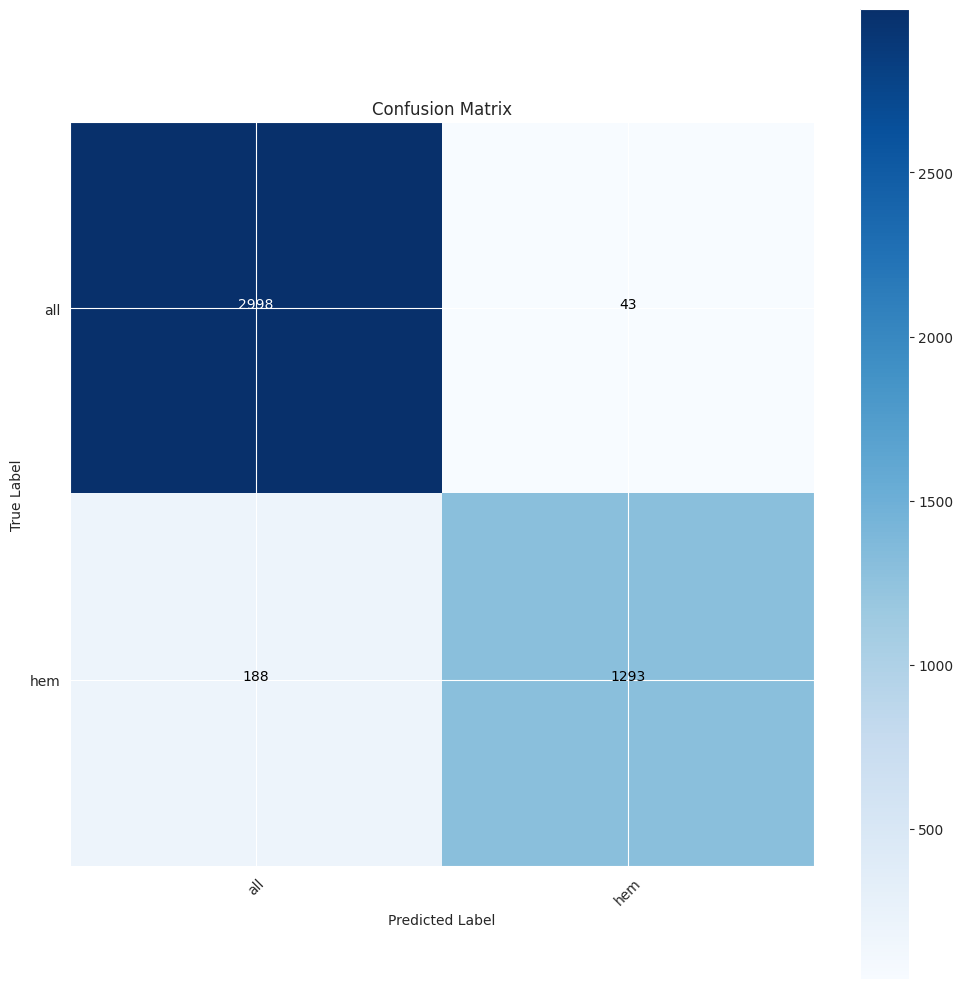

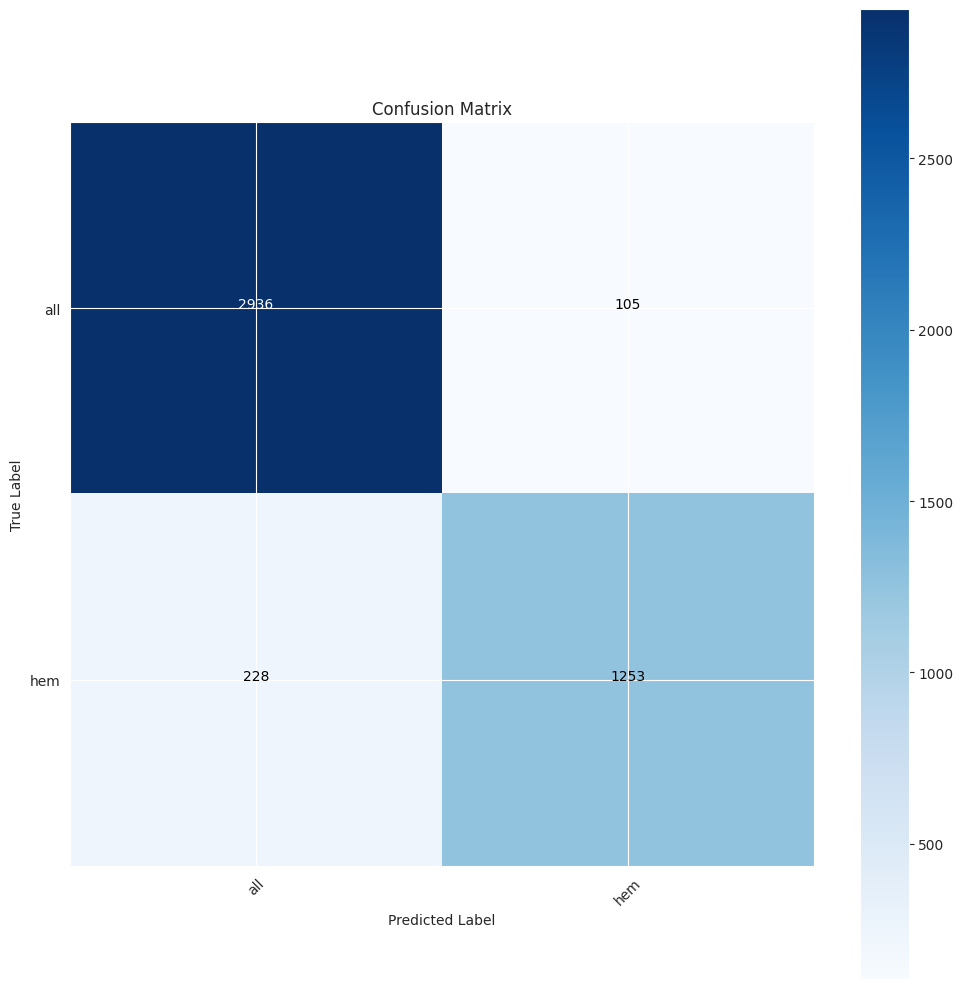

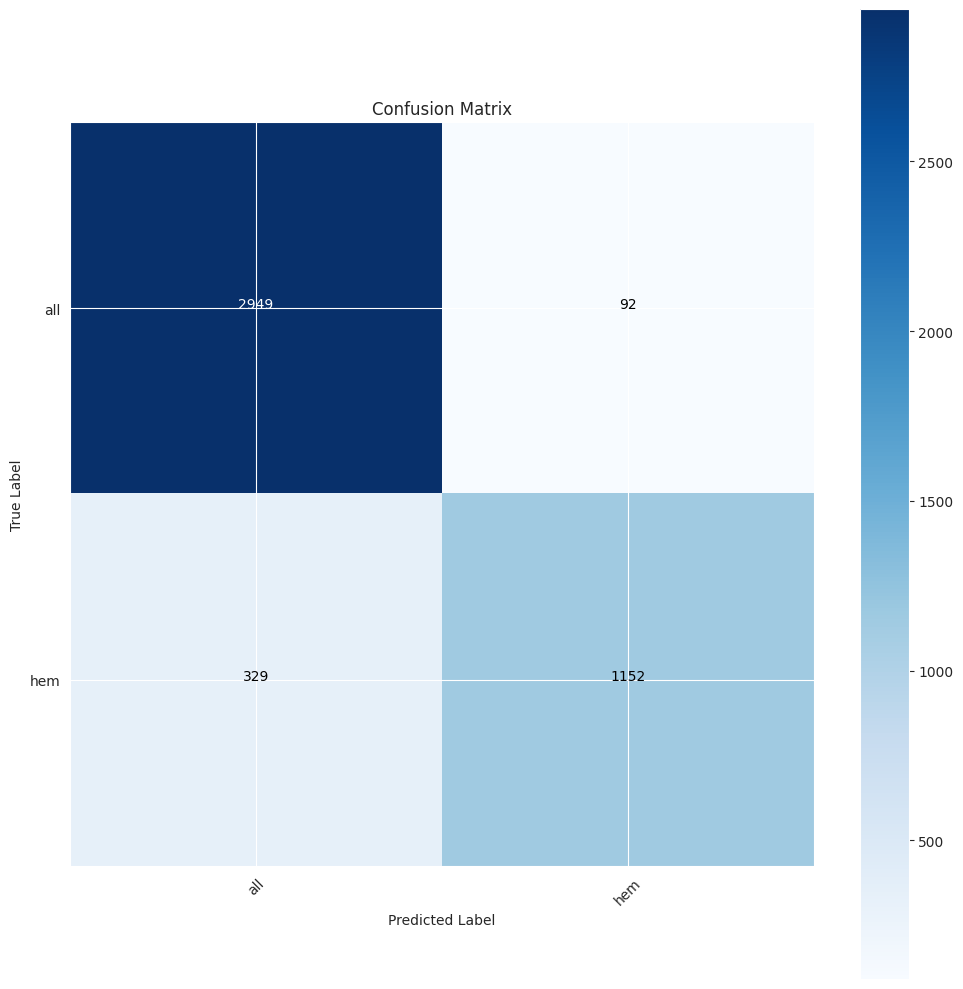

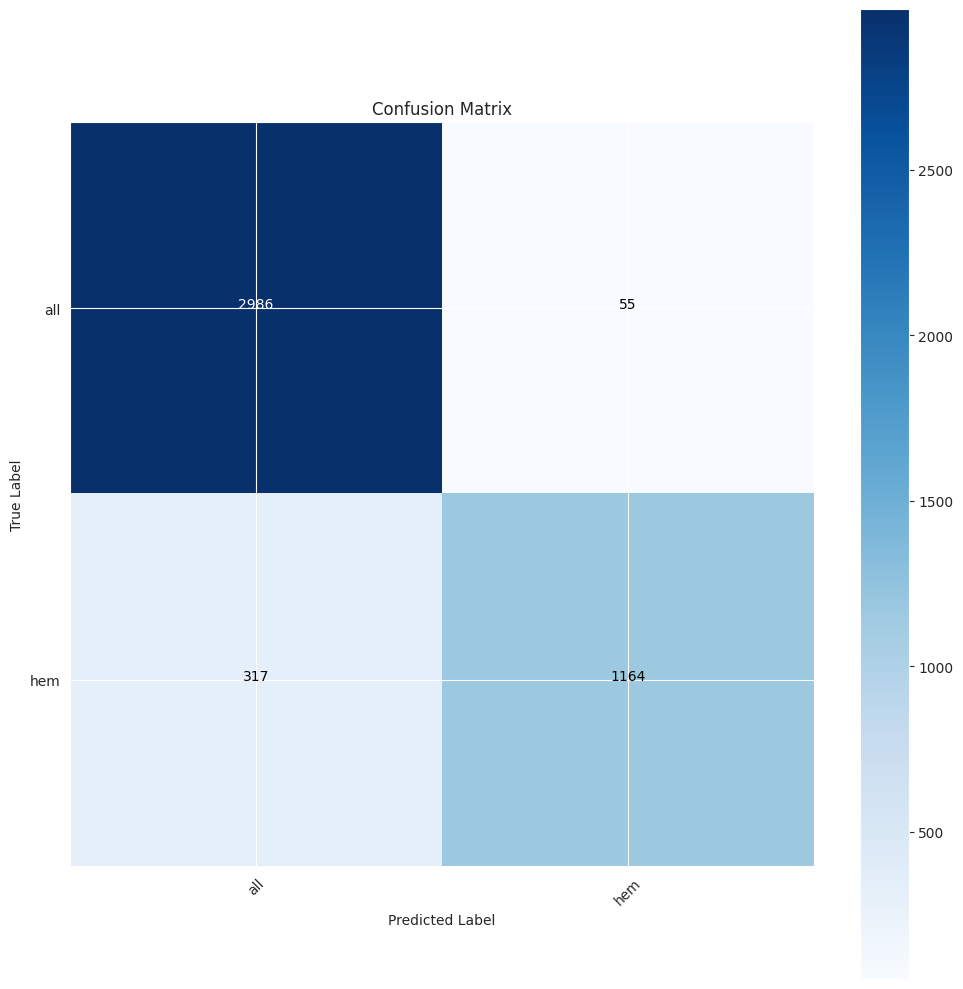

In [16]:
# Make predictions on the validation set
base_model_predictions_val = []

# Storing metrics per model
acc_scores = []
pre_scores = []
w_pre_scores = []
rec_scores = []
w_rec_scores = []
f1_scores = []
w_f1_scores = []

for model in [model1, model2,model3,model4]:
    predictions_val = model.predict_generator(test_gen, verbose= 1)
    base_model_predictions_val.append(predictions_val[:, 0])  # Extract the probability for the 0 class (index 0)

    y_pred = np.argmax(predictions_val, axis=1)
    g_dict = test_gen.class_indices
    classes = list(g_dict.keys())

    # Confusion matrix (per model)
    cm = confusion_matrix(test_gen.classes, y_pred)
    plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')

    # Classification report (per model)
    print(classification_report(test_gen.classes, y_pred, target_names= classes, digits= 4))

    # Append metrics
    acc_scores.append(accuracy_score(test_gen.classes, y_pred))
    pre_scores.append( precision_score(test_gen.classes, y_pred, pos_label= 0))
    w_pre_scores.append( precision_score(test_gen.classes, y_pred, average='weighted'))
    rec_scores.append(recall_score(test_gen.classes, y_pred, pos_label= 0))
    w_rec_scores.append(recall_score(test_gen.classes, y_pred, average='weighted'))
    f1_scores.append(f1_score(test_gen.classes, y_pred, pos_label= 0))
    w_f1_scores.append(f1_score(test_gen.classes, y_pred, average='weighted'))

### **Use the meta model to make the final predictions**

In [17]:
# Stack the base model predictions vertically
meta_input_val = np.vstack(base_model_predictions_val)

# Transpose the meta_input to match the input shape of the meta model
meta_input_val = meta_input_val.T

predictions_val_meta = meta_model.predict(meta_input_val)

142/142 [==============================] - 0s 2ms/step


### **Evaluate the stacking ensemble's final predictions**


Confusion Matrix, Without Normalization
[[3004   37]
 [ 171 1310]]

              precision    recall  f1-score   support

         all     0.9461    0.9878    0.9665      3041
         hem     0.9725    0.8845    0.9264      1481

    accuracy                         0.9540      4522
   macro avg     0.9593    0.9362    0.9465      4522
weighted avg     0.9548    0.9540    0.9534      4522



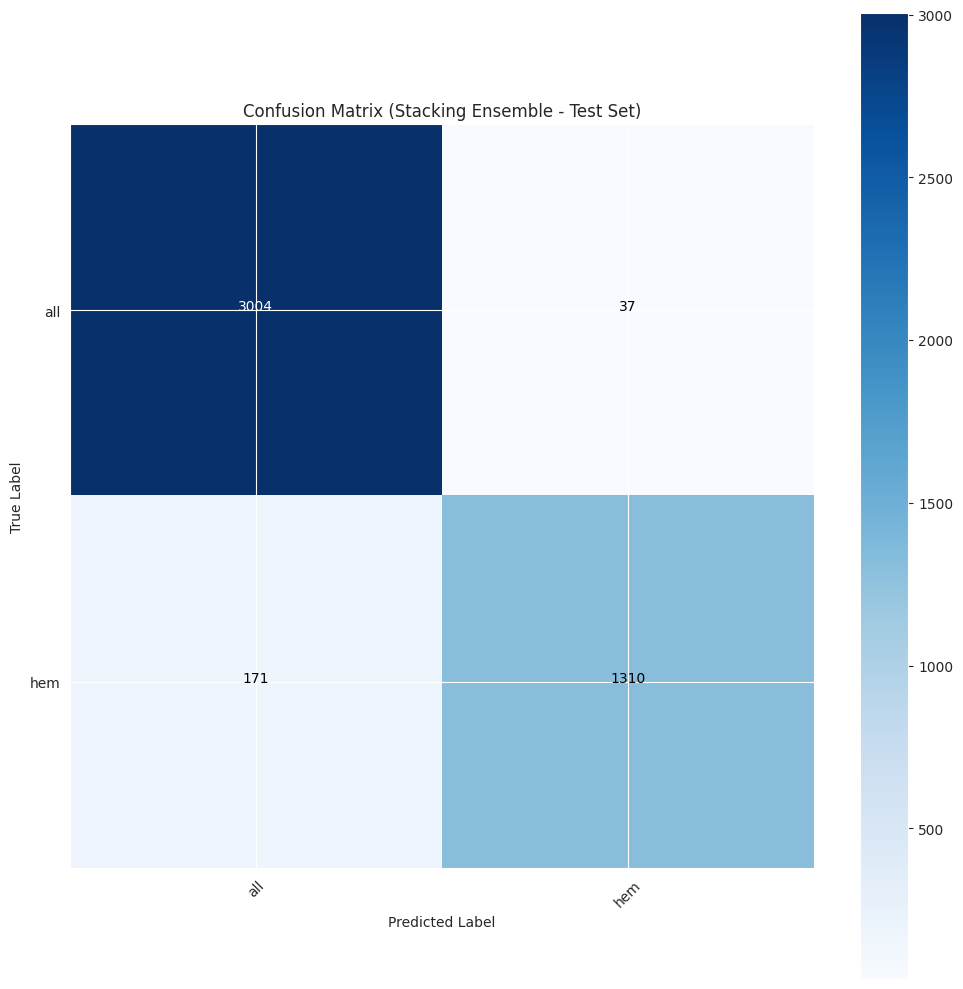

In [18]:
# Convert the sigmoid predictions to class labels (0 or 1)
predicted_labels_val = (predictions_val_meta > 0.5).astype(int)

g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
print('')
cm = confusion_matrix(test_gen.classes, predicted_labels_val)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix (Stacking Ensemble - Test Set)')

# Classification report
print('')
print(classification_report(test_gen.classes, predicted_labels_val, target_names= classes, digits= 4))

# **Threshold adjustments**

In [19]:
y_pred_probs = np.copy(predictions_val_meta)

# experimenting thresholds
acc_list = []
pre_list = []
w_pre_list = []
rec_list = []
w_rec_list = []
f1_list = []
w_f1_list = []

threshold = 0.6

for x in range(101):
  threshold = round(0.6 - x*0.005, 3)
  y_pred_adjusted = (y_pred_probs >= threshold).astype(int) # Applying the adjusted thresholds for each class

  # Confusion matrix
  cm = confusion_matrix(test_gen.classes, y_pred_adjusted)
  print()
  print(f'Confusion Matrix - Thresholds: {round(1-threshold,3)}, {threshold}')
  print(cm)
  # Classification report
  print(classification_report(test_gen.classes, y_pred_adjusted, target_names= classes, digits= 4))
  print()

  acc_list.append(accuracy_score(test_gen.classes, y_pred_adjusted))
  pre_list.append( precision_score(test_gen.classes, y_pred_adjusted, pos_label= 0))
  w_pre_list.append( precision_score(test_gen.classes, y_pred_adjusted, average='weighted'))
  rec_list.append(recall_score(test_gen.classes, y_pred_adjusted, pos_label= 0))
  w_rec_list.append(recall_score(test_gen.classes, y_pred_adjusted, average='weighted'))
  f1_list.append(f1_score(test_gen.classes, y_pred_adjusted, pos_label= 0))
  w_f1_list.append(f1_score(test_gen.classes, y_pred_adjusted, average='weighted'))


Confusion Matrix - Thresholds: 0.4, 0.6
[[3013   28]
 [ 195 1286]]
              precision    recall  f1-score   support

         all     0.9392    0.9908    0.9643      3041
         hem     0.9787    0.8683    0.9202      1481

    accuracy                         0.9507      4522
   macro avg     0.9590    0.9296    0.9423      4522
weighted avg     0.9521    0.9507    0.9499      4522



Confusion Matrix - Thresholds: 0.405, 0.595
[[3012   29]
 [ 194 1287]]
              precision    recall  f1-score   support

         all     0.9395    0.9905    0.9643      3041
         hem     0.9780    0.8690    0.9203      1481

    accuracy                         0.9507      4522
   macro avg     0.9587    0.9297    0.9423      4522
weighted avg     0.9521    0.9507    0.9499      4522



Confusion Matrix - Thresholds: 0.41, 0.59
[[3012   29]
 [ 194 1287]]
              precision    recall  f1-score   support

         all     0.9395    0.9905    0.9643      3041
         hem     0.9780  

### **Threshold optimization results**

In [20]:
# results
best_acc_ndx = np.argmax(np.array(acc_list))
best_pre_ndx = np.argmax(np.array(pre_list))
best_w_pre_ndx = np.argmax(np.array(w_pre_list))
best_rec_ndx = np.argmax(np.array(rec_list))
best_w_rec_ndx = np.argmax(np.array(w_rec_list))
best_f1_ndx = np.argmax(np.array(f1_list))
best_w_f1_ndx = np.argmax(np.array(w_f1_list))

print(f'For the threshold adjustments on test set predictions for the stacking ensemble')
print(f'Best accuracy           - threshold [{round(0.4+0.005*best_acc_ndx,3)},{round(0.6-0.005*best_acc_ndx,3)}] -> {round(acc_list[best_acc_ndx]*100,3)}%')
print(f'Best ALL precision      - threshold [{round(0.4+0.005*best_pre_ndx,3)},{round(0.6-0.005*best_pre_ndx,3)}] -> {round(pre_list[best_pre_ndx]*100,3)}%')
print(f'Best weighted precision - threshold [{round(0.4+0.005*best_w_pre_ndx,3)},{round(0.6-0.005*best_w_pre_ndx,3)}] -> {round(w_pre_list[best_w_pre_ndx]*100,3)}%')
print(f'Best ALL recall         - threshold [{round(0.4+0.005*best_rec_ndx,3)},{round(0.6-0.005*best_rec_ndx,3)}] -> {round(rec_list[best_rec_ndx]*100,3)}%')
print(f'Best weighted recall    - threshold [{round(0.4+0.005*best_w_rec_ndx,3)},{round(0.6-0.005*best_w_rec_ndx,3)}] -> {round(w_rec_list[best_w_rec_ndx]*100,3)}%')
print(f'Best ALL f1-score       - threshold [{round(0.4+0.005*best_f1_ndx,3)},{round(0.6-0.005*best_f1_ndx,3)}] -> {round(f1_list[best_f1_ndx]*100,3)}%')
print(f'Best weighted f1-score  - threshold [{round(0.4+0.005*best_w_f1_ndx,3)},{round(0.6-0.005*best_w_f1_ndx,3)}] -> {round(w_f1_list[best_w_f1_ndx]*100,3)}%')

For the threshold adjustments on test set predictions for the stacking ensemble
Best accuracy           - threshold [0.73,0.27] -> 95.754%
Best ALL precision      - threshold [0.9,0.1] -> 97.02%
Best weighted precision - threshold [0.73,0.27] -> 95.754%
Best ALL recall         - threshold [0.4,0.6] -> 99.079%
Best weighted recall    - threshold [0.73,0.27] -> 95.754%
Best ALL f1-score       - threshold [0.73,0.27] -> 96.88%
Best weighted f1-score  - threshold [0.73,0.27] -> 95.726%


### **Apply the optimal threshold and get adjusted metrics**

Threshold used for adjusted predictions is: [ 0.73 , 0.27 ]

Confusion matrix:
Confusion Matrix, Without Normalization
[[2981   60]
 [ 132 1349]]
              precision    recall  f1-score   support

         all     0.9576    0.9803    0.9688      3041
         hem     0.9574    0.9109    0.9336      1481

    accuracy                         0.9575      4522
   macro avg     0.9575    0.9456    0.9512      4522
weighted avg     0.9575    0.9575    0.9573      4522

Change in accuracy           : 0.686 %
Change in ALL precision      : 1.838 %
Change in weighted precision : 0.539 %
Change in ALL recall         : -1.052 %
Change in weighted recall    : 0.686 %
Change in ALL F1-score       : 0.449 %
Change in weighted F1-score  : 0.739 %


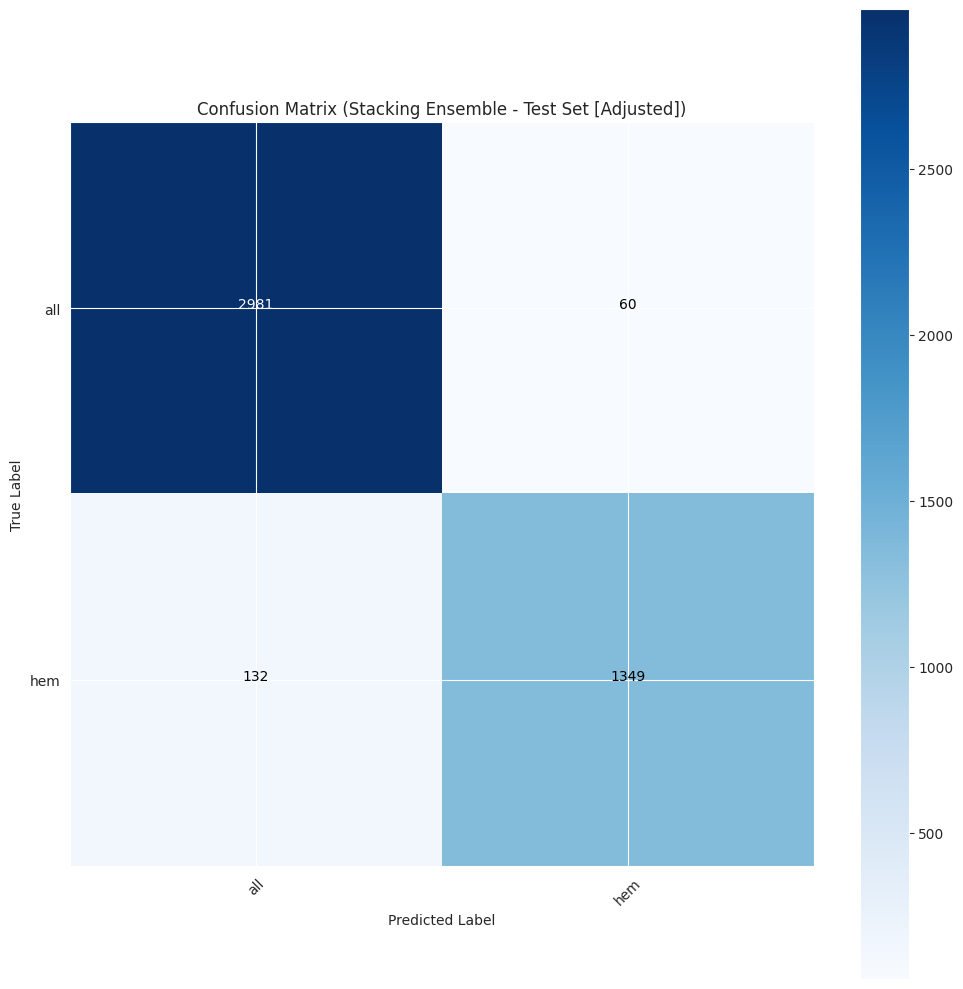

In [21]:
# Apply the threshold of the chosen criteria
best_ndx = best_w_f1_ndx # Here we use Weighted F1 score. Change here if you want a different criteria

threshold = round(0.6 - 0.005*best_ndx, 3)
y_pred_adjusted = (y_pred_probs >= threshold).astype(int) # Applying the adjusted thresholds for each class
cm = confusion_matrix(test_gen.classes, y_pred_adjusted)

#print adjusted metrics
print(f'Threshold used for adjusted predictions is: [ {round(0.4+0.005*best_ndx,3)} , {round(0.6-0.005*best_ndx,3)} ]')
print('')
print('Confusion matrix:')
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix (Stacking Ensemble - Test Set [Adjusted])')

print(classification_report(test_gen.classes, y_pred_adjusted, target_names= classes, digits= 4))

print(f'Change in accuracy           : {round((acc_list[best_ndx]-acc_list[0])*100,3)} %')
print(f'Change in ALL precision      : {round((pre_list[best_ndx]-pre_list[0])*100,3)} %')
print(f'Change in weighted precision : {round((w_pre_list[best_ndx]-w_pre_list[0])*100,3)} %')
print(f'Change in ALL recall         : {round((rec_list[best_ndx]-rec_list[0])*100,3)} %')
print(f'Change in weighted recall    : {round((w_rec_list[best_ndx]-w_rec_list[0])*100,3)} %')
print(f'Change in ALL F1-score       : {round((f1_list[best_ndx]-f1_list[0])*100,3)} %')
print(f'Change in weighted F1-score  : {round((w_f1_list[best_ndx]-w_f1_list[0])*100,3)} %')

# Append metrics of the adjusted performance
acc_scores.append(accuracy_score(test_gen.classes, y_pred_adjusted))
pre_scores.append( precision_score(test_gen.classes, y_pred_adjusted, pos_label= 0))
w_pre_scores.append( precision_score(test_gen.classes, y_pred_adjusted, average='weighted'))
rec_scores.append(recall_score(test_gen.classes, y_pred_adjusted, pos_label= 0))
w_rec_scores.append(recall_score(test_gen.classes, y_pred_adjusted, average='weighted'))
f1_scores.append(f1_score(test_gen.classes, y_pred_adjusted, pos_label= 0))
w_f1_scores.append(f1_score(test_gen.classes, y_pred_adjusted, average='weighted'))

# **Compare and display results**

### **Metrics for individual models and stacking ensemble**

In [22]:
print(f'          Acc     ALL-Pre W-Pre   ALL-Rec W-Rec   ALL-F1  W-F1')
for x in range(4):
  print(f'Model {x+1} : {round(acc_scores[x]*100,3)}%  {round(pre_scores[x]*100,3)}%  {round(w_pre_scores[x]*100,3)}%  {round(rec_scores[x]*100,3)}%  {round(w_rec_scores[x]*100,3)}%  {round(f1_scores[x]*100,3)}%  {round(w_f1_scores[x]*100,3)}% ')
print(f'Stacking: {round(acc_scores[4]*100,3)}%  {round(pre_scores[4]*100,3)}%  {round(w_pre_scores[4]*100,3)}%  {round(rec_scores[4]*100,3)}%  {round(w_rec_scores[4]*100,3)}%  {round(f1_scores[4]*100,3)}%  {round(w_f1_scores[4]*100,3)}% ')

          Acc     ALL-Pre W-Pre   ALL-Rec W-Rec   ALL-F1  W-F1
Model 1 : 94.892%  94.099%  94.978%  98.586%  94.892%  96.29%  94.82% 
Model 2 : 92.636%  92.794%  92.622%  96.547%  92.636%  94.633%  92.549% 
Model 3 : 90.69%  89.963%  90.828%  96.975%  90.69%  93.338%  90.46% 
Model 4 : 91.774%  90.403%  92.068%  98.191%  91.774%  94.136%  91.544% 
Stacking: 95.754%  95.76%  95.754%  98.027%  95.754%  96.88%  95.726% 


### **Save adjusted test set predictions**

In [23]:
y_pred_probs2 = [1 - x for x in y_pred_probs]
y_pred_adjusted2 = [ 1 ^ x for x in y_pred_adjusted]
classes = [1 ^ x for x in test_gen.classes]

pred_test_cells = np.column_stack((meta_input_val, y_pred_probs2, y_pred_adjusted2, classes)) # for display
predictions = np.column_stack((test_gen.filenames, meta_input_val, y_pred_probs2, y_pred_adjusted2, classes)) # for saving to CSV

# Save to CSV files
predictions_df = pd.DataFrame(
    predictions, columns = ['filenames',
                            f'{model1_name}-all-prob',
                            f'{model2_name}-all-prob',
                            f'{model3_name}-all-prob',
                            f'{model4_name}-all-prob',
                            f'stack-top-{model_count}_all_prob',
                            f'stack-top-{model_count}_adjusted_pred',
                            'actual_class'])
predictions_df.to_csv(f'/content/drive/MyDrive/ClassCSV/ALL-9010-stacking-top-{model_count}-adjusted-test-set-preds.csv', index= False)
print('Saved test set predictions into a CSV file')
print('')

Saved test set predictions into a CSV file



## **Save meta model and weights**

In [24]:
# Save model and weights
meta_model.save(f'/content/drive/MyDrive/Models/ALL-9010-meta-model-top-{model_count}.h5')
print('')
print('Model successfully saved!')
meta_model.save_weights(f'/content/drive/MyDrive/Models/ALL-9010-meta-model-top-{model_count}-weights.h5')
print('Model weights successfully saved!')


Model successfully saved!
Model weights successfully saved!


# **Display adjusted predictions**

In [25]:
# print adjusted predictions
print(f'Table of adjusted predictions in test set')
print()
print(f'Threshold for ALL: {round(0.5+0.005*best_ndx,3)} Stacked Probability')
print()
print(f'Model 1: {model1_name}')
print(f'Model 2: {model2_name}')
print(f'Model 3: {model3_name}')
print(f'Model 4: {model4_name}')
print()
print('Labels: [0 - HEM, 1 - ALL]')
print('---------------------------------------------------------------------')
print('  Model 1    Model 2    Model 3    Model 4    StackProb  StackPred  ActualClass')

import sys
with np.printoptions(threshold=sys.maxsize, suppress= True, linewidth= 300):
    print(pred_test_cells)

Table of adjusted predictions in test set

Threshold for ALL: 0.83 Stacked Probability

Model 1: ConvNeXtTiny
Model 2: MobileNetV2
Model 3: DenseNet121
Model 4: InceptionV3

Labels: [0 - HEM, 1 - ALL]
---------------------------------------------------------------------
  Model 1    Model 2    Model 3    Model 4    StackProb  StackPred  ActualClass
[[0.99129069 0.98813498 0.95367104 0.97713292 0.98879313 1.         1.        ]
 [0.99678826 0.99642271 0.98595828 0.98909432 0.98986465 1.         1.        ]
 [0.99691999 0.99497283 0.98879099 0.99261475 0.99001926 1.         1.        ]
 [0.99601537 0.99626321 0.9882549  0.99017906 0.98989296 1.         1.        ]
 [0.99638855 0.99608541 0.98493898 0.9914996  0.9899562  1.         1.        ]
 [0.99584019 0.99237776 0.96950328 0.99219316 0.98983282 1.         1.        ]
 [0.99417007 0.98782468 0.97460848 0.9844504  0.98941302 1.         1.        ]
 [0.99143243 0.9961766  0.98102313 0.98632044 0.98952025 1.         1.        ]
 [0.98365